# Comparison between DFT and W90 bandstructures

In [18]:
# numerical module
import numpy as np

#setup plotting 
import matplotlib.pyplot as plt
plt.style.use('sci.mplstyle')

In [19]:
def read_band(fname, EFermi):
    bandData = np.loadtxt(fname)
    EF = EFermi
    kDist = np.unique(bandData[:, 0])
    numBand = len(bandData[bandData[:, 0] == kDist[1]])
    Bands = (np.reshape(bandData[:, 1], (-1, len(kDist))).T) - EF
    return kDist, Bands


In [20]:
# Fermi level
#EF = 0.7694      # [eV]without SOC
EF = 0.7177  # [eV] with SOC
# Band structure from the output of Wannier90
ks_w90, en_w90 = read_band('mos2_295_band.dat', EF)

# Band structrue from the output of Quantum ESPRESSO
ks_dft, en_dft = read_band('mos2.bands.gnu', EF)
# Unit of k points from DFT (2*pi/a)
k2 = 2*np.pi/3.19000
# Convert the unit of ks_dft to 1/Angstrom
ks_k2 = np.asarray(ks_dft)*k2
# High-symmetry labels
kLabel = (r'$\Gamma$', r'M', r'K', r'$\Gamma$')

# High-symmetry k-point positions [1/Å]
kNode  = [0.0000, 1.13707, 1.79354, 3.10650]

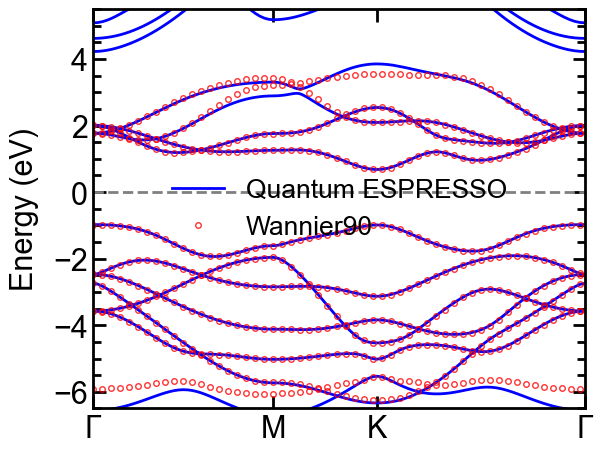

In [21]:
fig = plt.figure()

# Plot DFT data (only add label on the first iteration)
for i in range(en_dft.shape[1]):
    if i == 0:
        plt.plot(ks_k2, en_dft[:, i], color='blue', label='Quantum ESPRESSO')  # Only label the first line
    else:
        plt.plot(ks_k2, en_dft[:, i], color='blue')

for i in range(en_w90.shape[1]):
    if i == 0:
        plt.plot(
            ks_w90, en_w90[:, i],
            color='red', marker='o', linestyle='none',
            markersize=4.0, markevery=10,
            markerfacecolor='none', markeredgecolor='red',
            linewidth=1.0, alpha=0.8,
            label='Wannier90'
        )
    else:
        plt.plot(
            ks_w90, en_w90[:, i],
            color='red', marker='o', linestyle='none',
            markersize=4.0, markevery=10,
            markerfacecolor='none', markeredgecolor='red',
            linewidth=1.0, alpha=0.8
        )


# Add a horizontal line at y=0 (for reference)
plt.axhline(0.0, color='gray', ls='--')

# X-Axis
plt.xlabel('')
plt.xlim(kNode[0], kNode[-1])
# Add labels for high-symmetry points
plt.xticks(kNode, kLabel)

# Y-Axis
plt.ylabel('Energy (eV)')
plt.ylim(-6.5, 5.5)

# Hide x-axis minor ticks
plt.tick_params(axis='x', which='minor', bottom=False, top=False)

# Show the legend only once for DFT and W90
plt.legend()

# Adjust the layout
plt.tight_layout()

# Save the figure with high resolution
fig.savefig('./band_dft_w90.pdf', dpi=600)

# Show the plot
plt.show()

# Construct tight-binding model from `wannier90_hr.dat`

## Construct model

In [22]:
from pythtb import * # import TB model class

# read output from Wannier90 that should be in folder named "example_a"
# see instructions above for how to obtain the example output from 
# Wannier90

MoS2 = w90(r'\\wsl.localhost\Ubuntu-20.04\home\duytung1704\Wannier_OTM\29_4', 'mos2')

# get tight-binding model without hopping terms above 0.01 eV and set Fermi level 
my_model = MoS2.model(zero_energy=EF,min_hopping_norm=0.01)
my_model.display()

---------------------------------------
report of tight-binding model
---------------------------------------
k-space dimension           = 3
r-space dimension           = 3
number of spin components   = 1
periodic directions         = [0, 1, 2]
number of orbitals          = 9
number of electronic states = 9
lattice vectors:
 #  0  ===>  [  3.1903 ,     0.0 ,     0.0 ]
 #  1  ===>  [ -1.5952 ,  2.7629 ,     0.0 ]
 #  2  ===>  [     0.0 ,     0.0 , 17.4395 ]
positions of orbitals:
 #  0  ===>  [    -0.0 ,     0.0 ,     0.0 ]
 #  1  ===>  [    -0.0 ,     0.0 ,     0.0 ]
 #  2  ===>  [ -0.1475 ,  -0.295 ,     0.0 ]
 #  3  ===>  [   0.151 ,   0.302 ,     0.0 ]
 #  4  ===>  [     0.0 ,    -0.0 ,     0.0 ]
 #  5  ===>  [ -0.1234 , -0.2468 ,     0.0 ]
 #  6  ===>  [  0.1252 ,  0.2503 ,     0.0 ]
 #  7  ===>  [ -0.0123 , -0.0247 ,     0.0 ]
 #  8  ===>  [  0.0124 ,  0.0247 ,     0.0 ]
site energies:
 #  0  ===>   -3.1882
 #  1  ===>   -3.1229
 #  2  ===>   -1.9366
 #  3  ===>   -1.9366
 #  4  

## Bandstructure

In [23]:
# ===== PATH for MoS₂ monolayer =====
path_mono = [
    [0.00000, 0.00000, 0.00000],   # Γ
    [0.33333, 0.33333, 0.00000],   # K
    [0.50000, 0.00000, 0.00000],   # M
    [0.00000, 0.00000, 0.00000]    # Γ
]

k_label = (r'$\Gamma$', r'K', r'M', r'$\Gamma$')

# call k_path for 1D bandstructure interpolation
(k_vec, k_dist, k_node) = my_model.k_path(path_mono, 201)

# calculate bands along this path
evals = my_model.solve_all(k_vec)


----- k_path report begin ----------
real-space lattice vectors
 [[ 3.19032  0.       0.     ]
 [-1.59516  2.76289  0.     ]
 [ 0.       0.      17.4395 ]]
k-space metric tensor
 [[0.131   0.0655  0.     ]
 [0.0655  0.131   0.     ]
 [0.      0.      0.00329]]
internal coordinates of nodes
 [[0.      0.      0.     ]
 [0.33333 0.33333 0.     ]
 [0.5     0.      0.     ]
 [0.      0.      0.     ]]
reciprocal-space lattice vectors
 [[0.31345 0.18097 0.     ]
 [0.      0.36194 0.     ]
 [0.      0.      0.05734]]
cartesian coordinates of nodes
 [[0.      0.      0.     ]
 [0.10448 0.18097 0.     ]
 [0.15672 0.09048 0.     ]
 [0.      0.      0.     ]]
list of segments:
  length = 0.20896  from  [0. 0. 0.]  to  [0.33333 0.33333 0.     ]
  length = 0.10448  from  [0.33333 0.33333 0.     ]  to  [0.5 0.  0. ]
  length = 0.18097  from  [0.5 0.  0. ]  to  [0. 0. 0.]
node distance list: [0.      0.20896 0.31345 0.49442]
node index list:    [  0  85 127 200]
----- k_path report end ------------


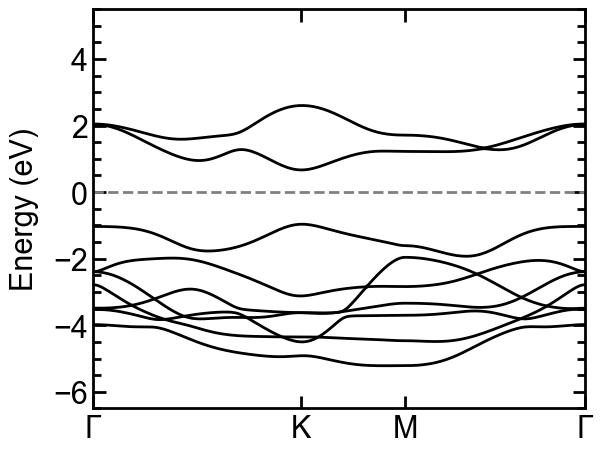

In [24]:
# plotting the tight-binding model
fig = plt.figure()
for i in range(evals.shape[0]):
    plt.plot(k_dist, evals[i], color='black')

plt.axhline(0.0, color='gray', ls='--')
# X-axis
plt.xlabel('')
plt.xlim(k_dist[0],k_dist[-1])
plt.xticks(k_node, k_label)
# Y-axis
plt.ylabel('Energy (eV)')
plt.ylim(-6.5, 5.5)
# Hide x-axis minor ticks
plt.tick_params(axis='x', which='minor', bottom=False, top=False)

plt.tight_layout()
fig.savefig('./band_TB.png', dpi=600)
plt.show()

## Edge State

In [25]:
#Cut the slab in the x-direction
slab_model = my_model.cut_piece(20, 0, glue_edgs=False)

# compute the band structure in the entire band
path_slab = [
[0.5,  0.0],
[0.0,  0.0],
[0.5,  0.0]
]

# labels of the nodes
k_label = (r'$\overline{X}$', r'$\overline{\Gamma}$', r'$\overline{X}$')

# call function k_path to construct the actual path
(k_vec_slab, k_dist_slab ,k_node_slab) = slab_model.k_path(path_slab,201)

# calculate the model
evals_slab = slab_model.solve_all(k_vec_slab)

----- k_path report begin ----------
real-space lattice vectors
 [[-1.59516  2.76289  0.     ]
 [ 0.       0.      17.4395 ]]
k-space metric tensor
 [[0.09825 0.     ]
 [0.      0.00329]]
internal coordinates of nodes
 [[0.5 0. ]
 [0.  0. ]
 [0.5 0. ]]
list of segments:
  length = 0.15672  from  [0.5 0. ]  to  [0. 0.]
  length = 0.15672  from  [0. 0.]  to  [0.5 0. ]
node distance list: [0.      0.15672 0.31345]
node index list:    [  0 100 200]
----- k_path report end ------------



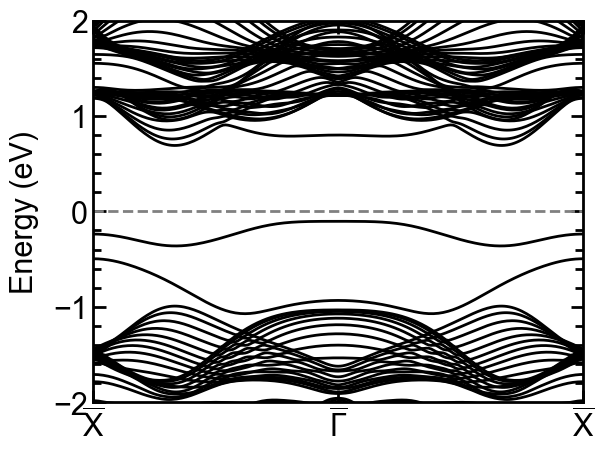

In [26]:
# plotting the edge states
fig = plt.figure()
for i in range(evals_slab.shape[0]):
    plt.plot(k_dist_slab, evals_slab[i], color='black')

plt.axhline(0.0, color='gray', ls='--')
# X-axis
plt.xlabel('')
plt.xlim(k_dist_slab[0], k_dist_slab[-1])
plt.xticks(k_node_slab, k_label)
# Y-axis
plt.ylabel('Energy (eV)')
plt.ylim(-2, 2)
# Hide x-axis minor ticks
plt.tick_params(axis='x', which='minor', bottom=False, top=False)

plt.tight_layout()
fig.savefig('./edge_state.png', dpi=600)
plt.show()

## PLOTTING DENSITY OF STATES (DOS)


C:\Users\PC\AppData\Local\Temp\ipykernel_20436\1568077655.py:22: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_20436\1568077655.py:25: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.savefig('./DOS_MOS2.pdf', dpi=600)
c:\Users\PC\luan_an\newbie\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


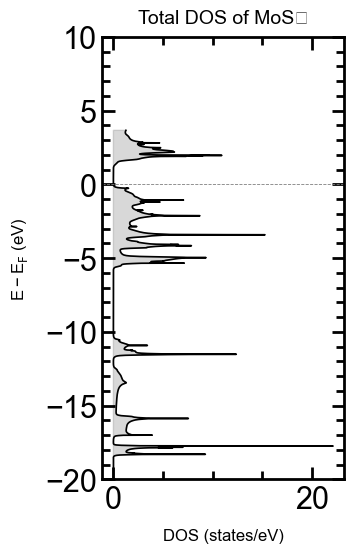

In [32]:
fermi = 0.0  # cập nhật nếu bạn biết rõ giá trị mức Fermi
dos_file = "mos2-dos.dat"

# === Đọc dữ liệu ===
data = np.loadtxt(dos_file)
energy = data[:, 0] - fermi  # dịch mức Fermi về 0
dos = data[:, 1]

# === Tạo figure đúng cách ===
fig, ax = plt.subplots(figsize=(4, 6))

# === Vẽ ===
ax.plot(dos, energy, color='black', lw=1.2)
ax.fill_betweenx(energy, 0, dos, color='gray', alpha=0.3)
ax.set_ylim(-20, 10)  # điều chỉnh theo phạm vi năng lượng của bạn

# === Trang trí ===
ax.axhline(0, color='gray', linestyle='--', lw=0.6)
ax.set_xlabel("DOS (states/eV)", fontsize=12)
ax.set_ylabel(r"$E - E_\mathrm{F}$ (eV)", fontsize=12)
ax.set_title("Total DOS of MoS₂", fontsize=14)
plt.tight_layout()

# === Lưu đúng ===
fig.savefig('./DOS_MOS2.pdf', dpi=600)
plt.show()